This is a working notebook exploring if SVM is a useful tool to separate shadow and floodwaters. 

The notebook uses the rasterio.sample method to extract data at specific points identified in an ArcGIS shapefile.
This data is then used to fit/train and test a SVM model using both a linear and rbf kernel. 
The accuracy score and confusion matrix are calculated to quantify how well the model fits the test data. 

Inputs to model include combination of index raw values for:
"Dark" parameter, MBI, MSI, NDVI, NDWI0, NDWI1, NDWI2, NDWIcoastal-MSI, NDWIgreen-MSI
These index values are calculated using the notebook "ndwi_msi_with_modules"

The model is calibrated and then validated on data not included in either the training or intial testing of the model. 

Training/test data set represents 60% of overall dataset. Final validation is done with remaining 40%

In [1]:
# Import necessary packages
import os
import numpy as np
# import numpy.ma as ma
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import geopandas as gpd
import rasterio as rio
# from rasterio.mask import mask
import earthpy as et
import earthpy.spatial as es

from sklearn.svm import SVC 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.covariance import EmpiricalCovariance

In [2]:
# Set working directory
os.chdir(os.path.join(et.io.HOME, 'earth-analytics','spring-2019', 'flood-detection'))
os.environ["PROJ_LIB"] = r"C:\Users\katy\Anaconda3\envs\earth-analytics-python\Library\share"

## Try SVM on raw data including: dark parameter, NDWIs, NDVI, MSI, and MBI data

In [3]:
# Read in data for aoi identified. 
# Raw metric files must be available and named appropriately per ndwi_msi_with_modules notebook.
# sample points availabel from data folder (?)
aoi = 'koumassi_focus_ps'
sample_pts_path = os.path.join("validation","vector-data\\")
raw_path = os.path.join("dg-data",aoi,"outputs","indices_and_mask_files")
raw_list = glob(raw_path+"\\"+"*raw*")
raw_list.sort()
sample_pts = gpd.read_file(sample_pts_path+"validation_points_koumassi_60_percent.shp")
validation_sample_pts = gpd.read_file(sample_pts_path+"validation_points_koumassi_40_percent.shp")

# Create tuples of all x coordinates and y coordinates 
x_coords = tuple(sample_pts.geometry.x)
y_coords = tuple(sample_pts.geometry.y)

In [ ]:
# sampled_values = []
i = 0
index_list = []
filename=[]

for raw in raw_list:
    sampled_values = []
    
    # Sample raster at each combo of x and y coordinates
    with rio.open(raw) as src:
        for val in src.sample(zip(x_coords, y_coords)):
            i = i+1
        # Note that each val is an individual numpy array
        # print(val.shape)
            sampled_values.append(val)
        arr = np.array([sampled_values]).squeeze()
        index_list.append([arr])
        filename.append(raw[57:78])
        

labels = filename
index_df = pd.DataFrame(np.concatenate(index_list))
index_df = index_df.transpose()
index_df.columns=labels
filepath = "validation\\"+"raw_index_values.csv"
index_df.to_csv(filepath) 

In [4]:
# Need to merge raw_index_values from above with classvalues from arcgis

# validation_data = pd.read_csv("validation\\Masks_testpoints.csv")
#validation_data = pd.read_csv("validation\\Index_value_testpoints.csv")
train_data = pd.read_csv("validation\\raw_index_values_60_percent.csv")
# test_data = pd.read_csv("validation\\AllData_Test.csv")
# mask_train_data = pd.read_csv("validation\\Mask_AllData_Train.csv")
# mask_test_data = = pd.read_csv("validation\\Mask_AllData_Train.csv")

In [ ]:
# type(validation_data)

In [ ]:
# Xtrain = train_data.iloc[:,[2,3,4,5,6]].values
# ytrain = train_data.iloc[:,1].values

In [ ]:
# Xtest = test_data.iloc[:,[2,3,4,5,6,]].values
# ytest = test_data.iloc[:,1].values

In [5]:
X = train_data.iloc[:,[2,3,4,9,11]].values
y = train_data.iloc[:,1].values

In [6]:
print(X.shape, y.shape)
# print(Xtrain.shape, ytrain.shape)

(604, 5) (604,)


In [7]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.4)

In [8]:
clf = SVC(kernel='linear')
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)
accuracy_score(ytest, ypred)

0.9380165289256198

In [ ]:
# Xtrain2, Xtest2, ytrain2, ytest2 = train_test_split(X, y)

In [9]:
clf_rbf = SVC(kernel='rbf')
clf_rbf.fit(Xtrain, ytrain)
ypred_rbf = clf_rbf.predict(Xtest)
accuracy_score(ytest, ypred_rbf)

C:\Users\katy\Anaconda3\envs\earth-analytics-python\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.9173553719008265

[[127   3   0]
 [  9  41   0]
 [  1   2  59]]


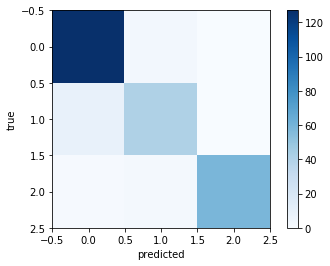

In [10]:
#Print confusion matrix for linear kernel SVM
print(confusion_matrix(ytest, ypred))

plt.imshow(confusion_matrix(ytest, ypred),
           cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted');

[[128   2   0]
 [ 15  35   0]
 [  0   3  59]]


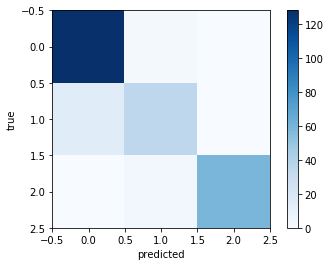

In [11]:
#Print confusion matrix for rbf kernel SVM
print(confusion_matrix(ytest, ypred_rbf))

plt.imshow(confusion_matrix(ytest, ypred_rbf),
           cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted');

In [ ]:
# Try Maximum Likelihood Estimator covariance model ?

In [ ]:
# cov = EmpiricalCovariance().fit(Xtrain)
# ypred_cov = cov.predict(Xtest)
# accuracy_score(ytest, ypred_cov)

Linear kernel appears to be better fit for data, depending on which parameters are included in model.
Tried playing with different combinations of indices. Current model includes the following combination:

- Dark parameter
- MBI
- MSI
- NDVI
- NDWIcoastal - MSI
- NDWIgreen - MSI

# Validation with 40% of data held back from SVM model development

In [18]:
# Create tuples of all x coordinates and y coordinates 
x_valid_coords = tuple(validation_sample_pts.geometry.x)
y_valid_coords = tuple(validation_sample_pts.geometry.y)

# sampled_values = []
i = 0
index_valid_list = []
filename=[]

for raw in raw_list:
    sampled_values = []
    
    # Sample raster at each combo of x and y coordinates
    with rio.open(raw) as src:
        for val in src.sample(zip(x_valid_coords, y_valid_coords)):
            i = i+1
        # Note that each val is an individual numpy array
        # print(val.shape)
            sampled_values.append(val)
        arr = np.array([sampled_values]).squeeze()
        index_valid_list.append([arr])
        filename.append(raw[57:78])
        

labels = filename
index_valid_df = pd.DataFrame(np.concatenate(index_valid_list))
index_valid_df = index_valid_df.transpose()
index_valid_df.columns=labels
filepath = "validation\\"+"validation_raw_index_values.csv"
index_valid_df.to_csv(filepath) 

In [24]:
valid_data = pd.read_csv("validation\\validation_raw_index_40_percent.csv")
Xvalid = valid_data.iloc[:,[2,3,4,9,11]].values
yvalid = valid_data.iloc[:,1].values

In [25]:
ypred_valid = clf.predict(Xvalid)
accuracy_score(yvalid, ypred_valid)

0.8957816377171216

[[199  10   0]
 [ 27  89   0]
 [  2   3  73]]


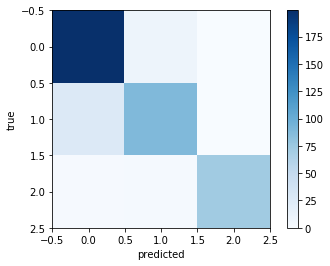

In [28]:
#Print confusion matrix for linear kernel SVM
print(confusion_matrix(yvalid, ypred_valid))

plt.imshow(confusion_matrix(yvalid, ypred_valid),
           cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted');

In [26]:
ypred_rbf_valid = clf_rbf.predict(Xvalid)
accuracy_score(yvalid, ypred_rbf_valid)

0.8660049627791563

[[204   3   2]
 [ 44  72   0]
 [  0   5  73]]


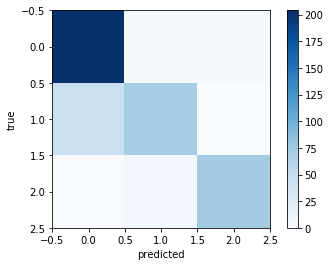

In [29]:
#Print confusion matrix for rbf kernel SVM
print(confusion_matrix(yvalid, ypred_rbf_valid))

plt.imshow(confusion_matrix(yvalid, ypred_rbf_valid),
           cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted');

Code from PyCon 2015 Jake VanderPlas presentation 

In [ ]:
# def plot_svc_decision_function(clf, ax=None):
#     """Plot the decision function for a 2D SVC"""
#     if ax is None:
#         ax = plt.gca()
#     x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
#     y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
#     Y, X = np.meshgrid(y, x)
#     P = np.zeros_like(X)
#     for i, xi in enumerate(x):
#         for j, yj in enumerate(y):
#             P[i, j] = clf.decision_function([[xi, yj]])
#     # plot the margins
#     ax.contour(X, Y, P, colors='k',
#                levels=[-1, 0, 1], alpha=0.5,
#                linestyles=['--', '-', '--'])

In [ ]:
# def plot_svc_decision_function(model, ax=None, plot_support=True):
#     """Plot the decision function for a 2D SVC"""
#     if ax is None:
#         ax = plt.gca()
#     xlim = ax.get_xlim()
#     ylim = ax.get_ylim()
    
#     # create grid to evaluate model
#     x = np.linspace(xlim[0], xlim[1], 30)
#     y = np.linspace(ylim[0], ylim[1], 30)
#     Y, X = np.meshgrid(y, x)
#     xy = np.vstack([X.ravel(), Y.ravel()]).T
#     P = model.decision_function(xy).reshape(X.shape)
    
#     # plot decision boundary and margins
#     ax.contour(X, Y, P, colors='k',
#                levels=[-1, 0, 1], alpha=0.5,
#                linestyles=['--', '-', '--'])
    
#     # plot support vectors
#     if plot_support:
#         ax.scatter(model.support_vectors_[:, 0],
#                    model.support_vectors_[:, 1],
#                    s=300, linewidth=1, facecolors='none');
#     ax.set_xlim(xlim)
#     ax.set_ylim(ylim)

In [ ]:
# plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
# plot_svc_decision_function(clf);

In [ ]:
# from sklearn.grid_search import GridSearchCV
# param_grid = {'svc__C': [1, 5, 10, 50],
#               'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
# grid = GridSearchCV(model, param_grid)

# %time grid.fit(Xtrain, ytrain)
# print(grid.best_params_)

In [ ]:
# clf = SVC(C=50,kernel='rbf')
# clf.fit(X, y)

# plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
# plot_svc_decision_function(clf)
# plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
#             s=200, facecolors='none');

In [ ]:
# clf

In [ ]:
# def visualize_tree(estimator, X, y, boundaries=True,
#                    xlim=None, ylim=None):
#     estimator.fit(X, y)

#     if xlim is None:
#         xlim = (X[:, 0].min() - 0.1, X[:, 0].max() + 0.1)
#     if ylim is None:
#         ylim = (X[:, 1].min() - 0.1, X[:, 1].max() + 0.1)

#     x_min, x_max = xlim
#     y_min, y_max = ylim
#     xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
#                          np.linspace(y_min, y_max, 100))
#     Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

#     # Put the result into a color plot
#     Z = Z.reshape(xx.shape)
#     plt.figure()
#     plt.pcolormesh(xx, yy, Z, alpha=0.2, cmap='rainbow')
#     plt.clim(y.min(), y.max())

#     # Plot also the training points
#     plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow')
#     plt.axis('off')

#     plt.xlim(x_min, x_max)
#     plt.ylim(y_min, y_max)        
#     plt.clim(y.min(), y.max())

In [ ]:
# def plot_tree_interactive(X, y):
#     from sklearn.tree import DecisionTreeClassifier

#     def interactive_tree(depth=1):
#         clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
#         visualize_tree(clf, X, y)

#     from ipywidgets import interact
#     return interact(interactive_tree, depth=(1, 15))

In [ ]:
# plot_tree_interactive(X, y);

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# clf = RandomForestClassifier(n_estimators=1000, random_state=0)
# visualize_tree(clf, X, y, boundaries=False);